# Q1 Gillespie's Direct Algorithm and Stochastic Hallmarks

Investigate
1. Variability
2. Negative co-variances
3. Increased transients
4. Stochastic resonance
5. Extinctions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.fftpack import rfft, rfftfreq
import scipy.stats as stats
from random import random
from glob import glob
import networkx as nx
import ndlib.models.epidemics as ep

\begin{align}
\frac{dS}{dt} &= \mu -\beta SI - \mu S, \label{eq:dSdtDemo} \\
\frac{dI}{dt} &= \beta SI - \gamma I- I(\mu + \rho), \label{eq:dIdtDemo} \\
\frac{dR}{dt} &= \gamma I- \mu R. \label{eq:dRdtDemo}
\end{align}

In [17]:
beta_df = pd.read_csv("data/finalbeta.csv")
gamma_df = pd.read_csv("data/finalgamma.csv")
mu_df = pd.read_csv("data/finalmu.csv")
N_df = pd.read_csv("data/finalN.csv")
gamma_N_df = pd.read_csv("data/finalgamma_N.csv")

In [4]:
def determinsteSIR(previousState, t, beta, gamma, birth_rate):
    N = np.sum(previousState)
    state = np.empty(3)
    X,Y,Z = previousState
    state[0] = birth_rate - X*birth_rate - X*Y*beta
    state[1] = X*Y*beta   - Y*birth_rate - Y*gamma 
    state[2] = Y*gamma - Z*birth_rate
    return state
    

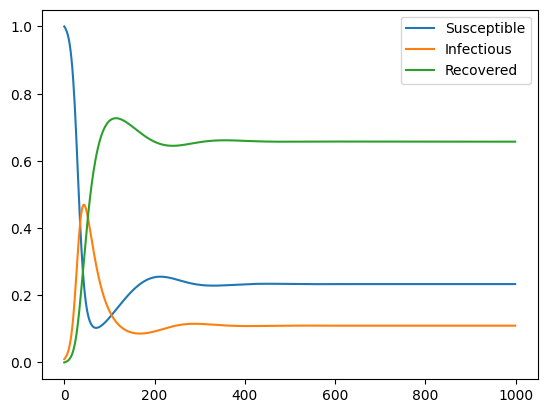

In [5]:
XYZ = [1, 0.01, 0]
t = np.linspace(0, 365, 1000)
beta = 1/2
gamma = 1/10
mu = 1/60

solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))
plt.plot(solved[:, 0], label = "Susceptible")
plt.plot(solved[:, 1], label = "Infectious")
plt.plot(solved[:, 2], label = "Recovered")
plt.legend(loc="best")

In [6]:
def stoch_sir(XYZ, N, tend, beta, gamma, mu):
    # Columns: SIR, Rows: Events [infect, recovery, birth, death S, death I, death R]
    change_matrix = np.array(
        [[-1, 1, 0],
         [0, -1, 1],
         [1,  0, 0],
         [-1, 0, 0],
         [0, -1, 0],
         [0,  0, -1]
         ])
    current_t = 0
    ts = 0.1
    T = [0]
    S = [XYZ[0]]
    I = [XYZ[1]]
    R = [XYZ[2]]

    while T[current_t] < tend:
        T.append(T[-1] + ts)
        S.append(XYZ[0])
        I.append(XYZ[1])
        R.append(XYZ[2])

        event_rates = ([(beta * XYZ[0] * XYZ[1])/N, gamma * XYZ[1],
                        mu * N,  mu * XYZ[0], mu * XYZ[1], mu * XYZ[2]])

        rand_1 = random()
        rand_2 = random()
        ts = -np.log(rand_1)/(np.sum(event_rates))

        p = rand_2 * np.sum(event_rates)
        event_index = min(np.nonzero(np.ravel(np.cumsum(event_rates) >= p))[0])

        XYZ = XYZ + change_matrix[event_index, :]

        current_t = current_t + 1
    return [T, S, I, R]


def run_simulations(number_of_runs, name, param, kwargs):
    for i in range(number_of_runs):
        df = pd.DataFrame(stoch_sir(**kwargs))
        for column in kwargs.keys():
            df[column] = [kwargs[column] for x in range(len(df))]
        df["group"] = ["S", "I", "R"]
        df.to_csv(f"seeddata/{name.capitalize()}{param:.2f}stochasticSIR{i+1}.csv", index=False)


# [T, S, I, R] = stoch_sir(XYZ)

# data_T = np.array(T)
# data_S = np.array(S)/10000
# data_I = np.array(I)/10000
# data_R = np.array(R)/10000

# data_T = np.array(T)
# data_S = np.array(S)/10000
# data_I = np.array(I)/10000
# data_R = np.array(R)/10000

# plt.plot(data_T, data_S, data_T, data_I, data_T, data_R)
# plt.xlabel("Days")
# plt.ylabel("Population Fraction")
# plt.legend(["Susceptible", "Infected", "Recovered"])
# plt.show()


## Investigate Simulation variability and Negative Co-variance

> Investigate how varying the model parameters changes the behavior of the stochastic dynamics. How do the related to the variance between runs and the negative covariance between $S$ and $I$.

> Compare the mean of the stochatic models to their deterministic counter parts

beta = 0.22
Covariance between S and I = -345625.20537815115

Variance for S = 4579972.46347489
Variance for I = 350080.09216311
Variance for R = 4309144.8964579115

beta = 1.27
Covariance between S and I = -138082.70540673417

Variance for S = 1758533.944979365
Variance for I = 1104795.4689525336
Variance for R = 2593375.6208724882

beta = 2.32
Covariance between S and I = -47179.175631504055

Variance for S = 950324.2947120103
Variance for I = 1337740.8985268374
Variance for R = 2161800.1225485313

beta = 3.37
Covariance between S and I = -32479.13693437664

Variance for S = 694640.3656803312
Variance for I = 1359364.8904444762
Variance for R = 2015568.9943743793



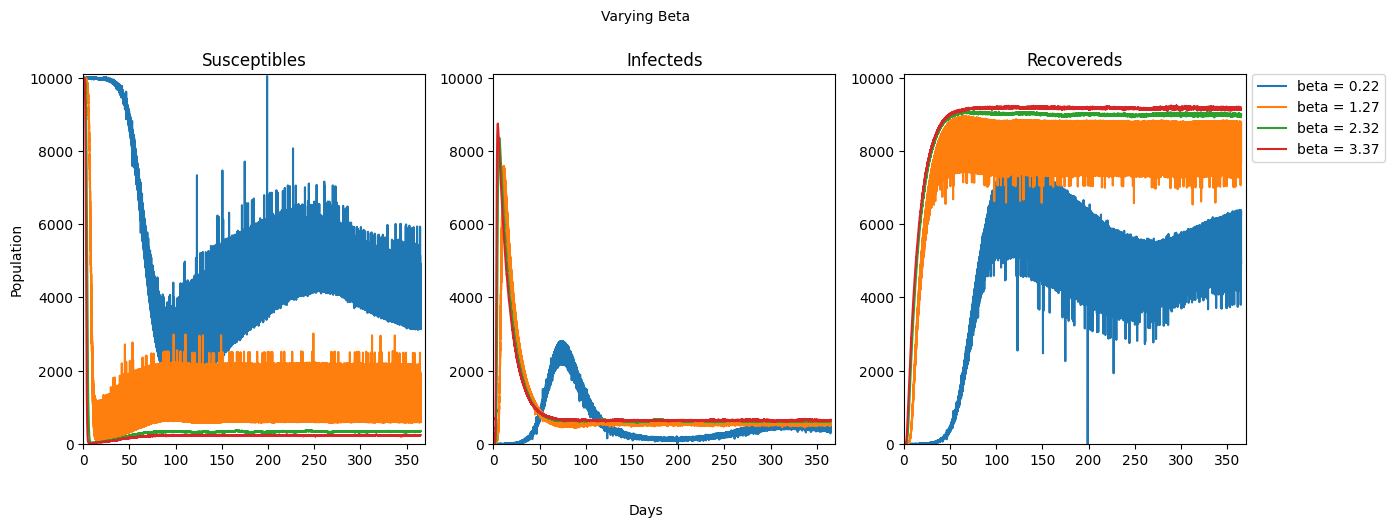

In [69]:
#Reading in the beta data (lol it rhymes hee hee. I'm a bit delirious right now). 

def sortHelper(x):
    try:
        return float(x)
    except: 
        return 100000
dfs = [beta_df, gamma_df, mu_df, N_df, gamma_N_df]

for df in dfs:
    df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1, inplace=True) 

sorted_columns = sorted(beta_df.columns, key=sortHelper)

beta_df = beta_df.reindex(columns=sorted_columns)

grouped = beta_df.groupby(["group"])
grouped_beta = beta_df.groupby(["group", "beta"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in beta_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data


for paramVal in beta_df["beta"].unique()[1::5]:
    axs[0].plot(numbers, grouped_beta.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_beta.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_beta.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"beta = {paramVal:.{2}f}")
    cov = np.cov(grouped_beta.loc[("S", paramVal)][:-6].dropna(), grouped_beta.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_beta.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_beta.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_beta.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Beta", ha='center', va='center', rotation='horizontal')
legend_labels = [f"beta = {paramVal:.{2}f}" for paramVal in beta_df["beta"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


[0.22 1.27 2.32 3.37]
[0.22 1.27 2.32 3.37]
[0.22 1.27 2.32 3.37]
[0.22 1.27 2.32 3.37]


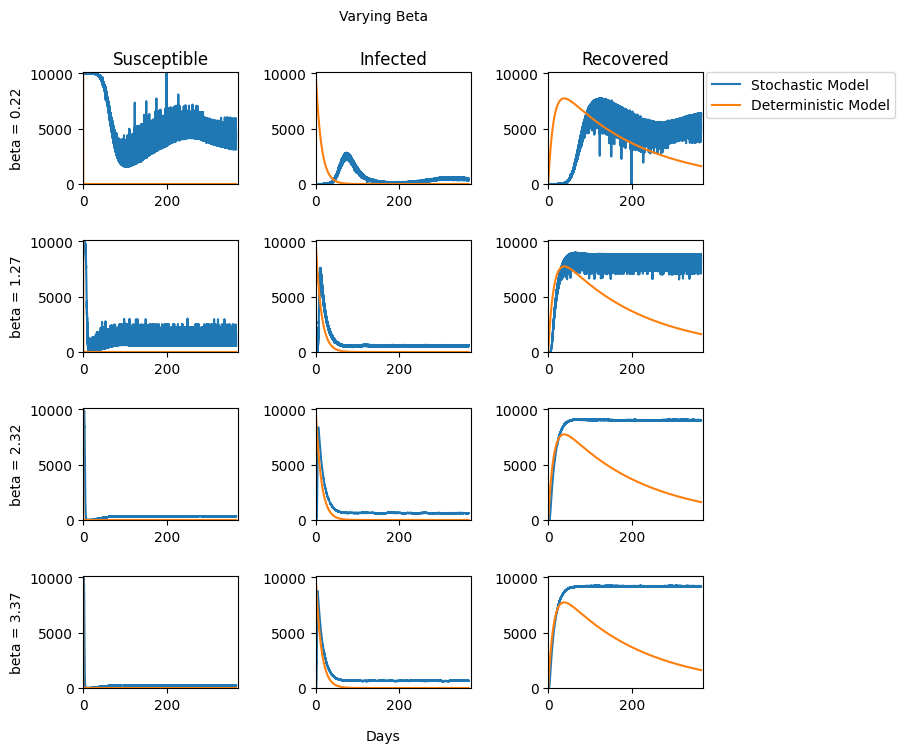

In [72]:
#Setting the figure
fig, axs = plt.subplots(4, 3)
fig.set_figwidth(8)
fig.set_figheight(8)
# Plotting the data

t1 = np.linspace(0, 365, len(numbers))


for i in range(4): 
    paramVals = beta_df["beta"].unique()[1::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (paramVals[i], beta_df["gamma"][0], beta_df["mu"][0]))
    axs[i,0].plot(numbers, grouped_beta.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_beta.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_beta.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"beta = {round(paramVals[i], 2)}")
    
    
axs[0,0].set_title("Susceptible")
axs[0,1].set_title("Infected")
axs[0,2].set_title("Recovered")


fig.text(0.5, 0.05, "Days", ha='center', va='center')
fig.text(0.5, 0.95, "Varying Beta", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 5.5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


gamma = 0.22
Covariance between S and I = -35396.72955239161

Variance for S = 748107.9335788947
Variance for I = 19772.217871259578
Variance for R = 691527.3923112763

gamma = 0.14
Covariance between S and I = -110615.79829192343

Variance for S = 1808768.777221275
Variance for I = 147259.15577635003
Variance for R = 1756228.3332891809

gamma = 0.29
Covariance between S and I = -15771.541749126553

Variance for S = 506887.1635694167
Variance for I = 5273.948517134851
Variance for R = 474101.2710355077

gamma = 0.42
Covariance between S and I = -0.12241481192293337

Variance for S = 505.0947846553558
Variance for I = 0.005381580038494857
Variance for R = 0.2208187946621726



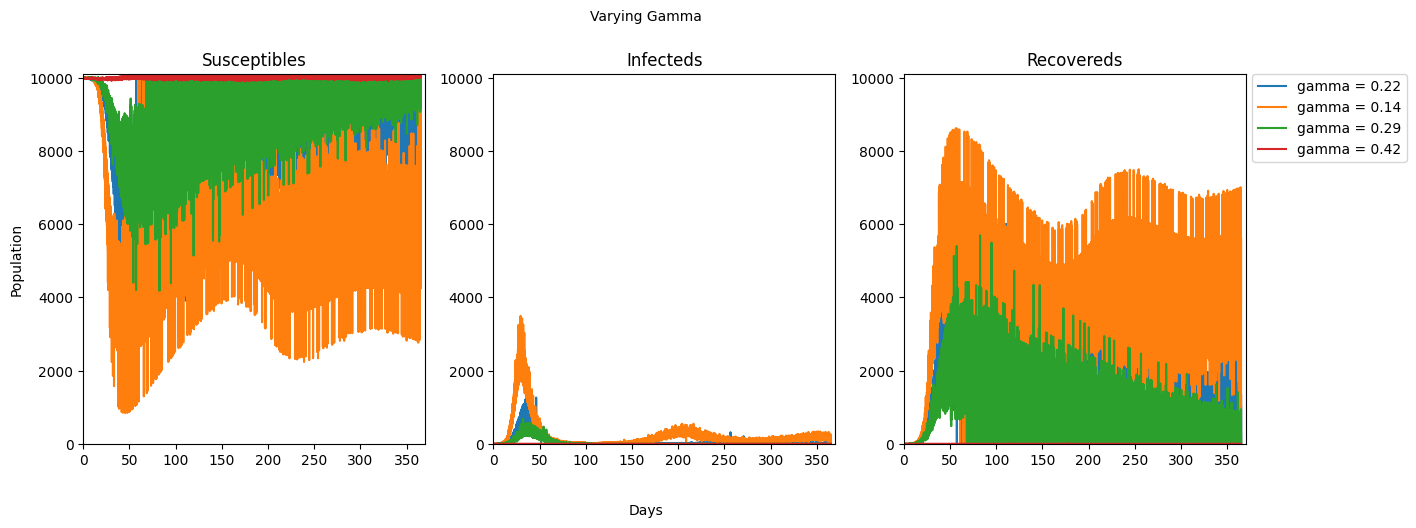

In [74]:
#Reading in the gamma data (lol it rhymes hee hee. I'm a bit delirious right now). 

grouped = gamma_df.groupby(["group"])
grouped_gamma = gamma_df.groupby(["group", "gamma"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in gamma_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data

for paramVal in gamma_df["gamma"].unique()[1::5]:
    axs[0].plot(numbers, grouped_gamma.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_gamma.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_gamma.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"gamma = {paramVal:.{2}f}")
    cov = np.cov(grouped_gamma.loc[("S", paramVal)][:-6].dropna(), grouped_gamma.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_gamma.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_gamma.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_gamma.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Gamma", ha='center', va='center', rotation='horizontal')
legend_labels = [f"gamma = {paramVal:.{2}f}" for paramVal in gamma_df["gamma"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


[0.03578947 0.16473684 0.31947368 0.44842105]


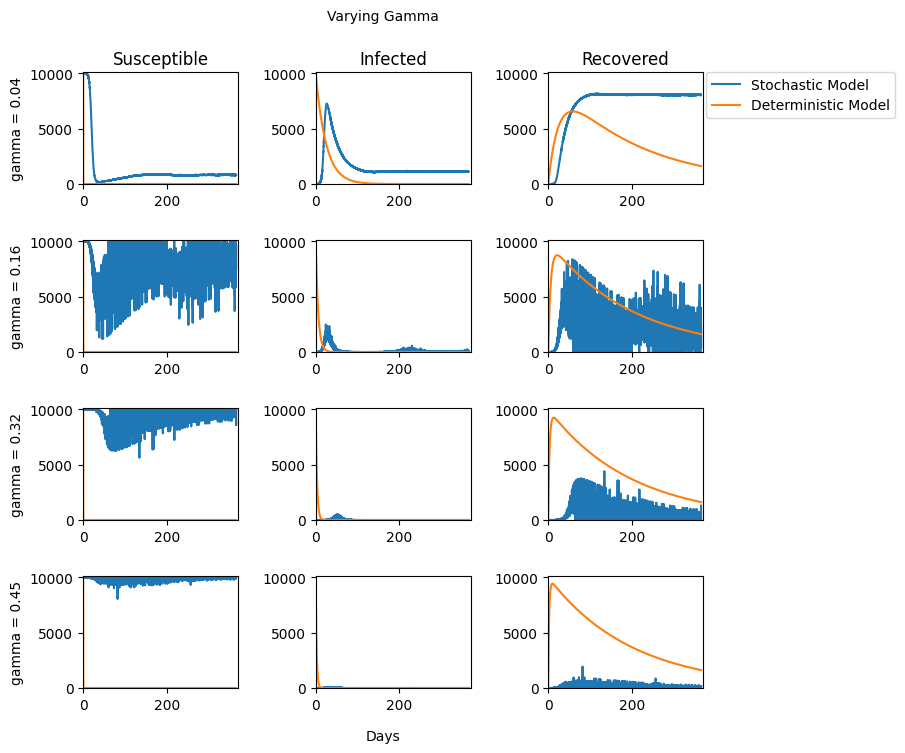

In [80]:
#Setting the figure
fig, axs = plt.subplots(4, 3)
fig.set_figwidth(8)
fig.set_figheight(8)
# Plotting the data

t1 = np.linspace(0, 365, len(numbers))


for i in range(4): 
    paramVals = gamma_df["gamma"].unique()[2::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (gamma_df["beta"][0], paramVals[i], gamma_df["mu"][0]))
    axs[i,0].plot(numbers, grouped_gamma.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_gamma.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_gamma.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"gamma = {round(paramVals[i], 2)}")

axs[0,0].set_title("Susceptible")
axs[0,1].set_title("Infected")
axs[0,2].set_title("Recovered")


fig.text(0.5, 0.05, "Days", ha='center', va='center')
fig.text(0.5, 0.95, "Varying Gamma", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 5.5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


mu = 0.02
Covariance between S and I = -444072.013500455

Variance for S = 2047138.142519091
Variance for I = 324274.7228861258
Variance for R = 1475193.5723492906

mu = 0.07
Covariance between S and I = -623933.7494230486

Variance for S = 1329278.0570609288
Variance for I = 324541.8537938637
Variance for R = 399028.5122747744



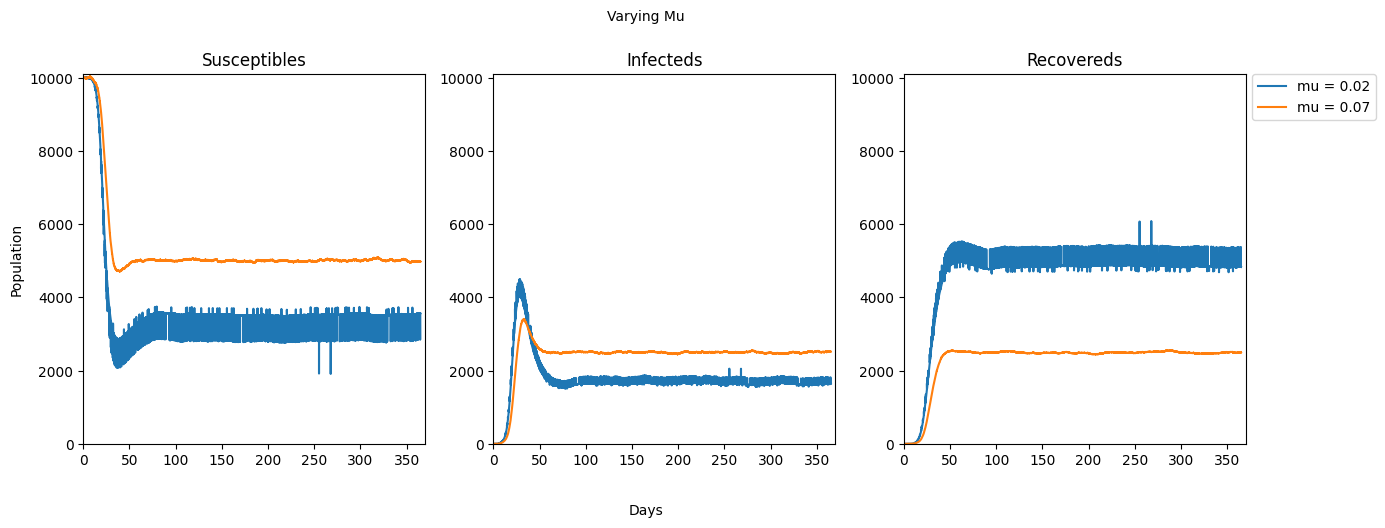

In [81]:
#Reading in the Mu data (lol it rhymes hee hee. I'm a bit delirious right now). 

grouped = mu_df.groupby(["group"])
grouped_mu = mu_df.groupby(["group", "mu"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in mu_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data

for paramVal in mu_df["mu"].unique()[1::5]:
    axs[0].plot(numbers, grouped_mu.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_mu.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_mu.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"mu = {paramVal:.{2}f}")
    cov = np.cov(grouped_mu.loc[("S", paramVal)][:-6].dropna(), grouped_mu.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_mu.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_mu.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_mu.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Mu", ha='center', va='center', rotation='horizontal')
legend_labels = [f"mu = {paramVal:.{2}f}" for paramVal in mu_df["mu"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


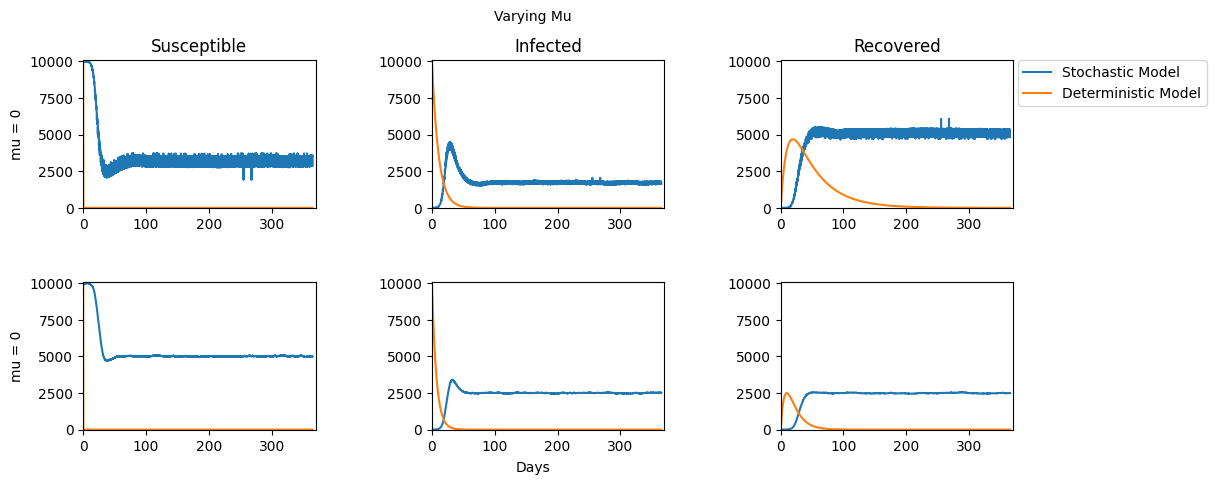

In [83]:
#Setting the figure
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)

# Plotting the data

t1 = np.linspace(0, 365, len(numbers))


for i in range(2): 
    paramVals = mu_df["mu"].unique()[1::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (mu_df["beta"][0], mu_df["gamma"][0], paramVals[i]))
    axs[i,0].plot(numbers, grouped_mu.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_mu.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_mu.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"mu = {round(paramVals[0])}")


axs[0,0].set_title("Susceptible")
axs[0,1].set_title("Infected")
axs[0,2].set_title("Recovered")


fig.text(0.5, 0.03, "Days", ha='center', va='center')
fig.text(0.5, 0.97, "Varying Mu", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 2.5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

In [ ]:
import os
def cleanfiles(file):
    file = os.path.basename(file)
    f = pd.read_csv(f"../seeddata/{file}")
    df = pd.DataFrame(f)
    new_names = {df.columns[x]: round(df.iloc[0, x], 2) for x in range(len(df.columns)-7)}
    df = df.rename(columns = new_names).loc[1:3, df.columns != 'XYZ']
    df = df.loc[:, ~df.columns.duplicated(keep='last')]
    df.to_csv(f"cleandata/{file}")
all_files = glob("../seeddata/Beta*.csv")
# Uncomment if new data needs to be cleaned
for file in all_files:
    cleanfiles(file)

In [14]:
# Uncomment to read in data
all_beta = glob("data/Beta*")

# Initialize an empty DataFrame to store the data
beta_df = pd.DataFrame()

# Read and concatenate the data from the files
for beta in all_beta[::-1]:
    new_df = pd.read_csv(beta, header=0)
    beta_df = pd.concat([beta_df, new_df], ignore_index=True)

#Grouping the DataFrame

def sortHelper(x):
    try:
        return float(x)
    except: 
        return 100000

sorted_columns = sorted(beta_df.columns, key=sortHelper)

beta_df = beta_df.reindex(columns=sorted_columns)
#beta_df = beta_df.drop('Unnamed: 0', axis=1)

grouped = beta_df.groupby(["group"])
grouped_beta = beta_df.groupby(["group", "beta"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in beta_df.columns[1:-7]]

# Plotting the data
#plt.plot(numbers, mean_stoch.loc["S"][:-7])
for i in beta_df["beta"].unique():
    plt.plot(numbers, grouped_beta.loc[("S", i)][:-6])

plt.show()


KeyError: 'group'

In [ ]:
# import os
# def cleanfiles(file):
#     file = os.path.basename(file)
#     f = pd.read_csv(f"../seeddata/{file}")
#     df = pd.DataFrame(f)
#     new_names = {df.columns[x]: round(df.iloc[0, x], 2) for x in range(len(df.columns)-7)}
#     df = df.rename(columns = new_names).loc[1:3, df.columns != 'XYZ']
#     df = df.loc[:, ~df.columns.duplicated(keep='last')]
#     df.to_csv(f"cleandata/{file}")
# all_files = glob("../seeddata/*.csv")
# ## Uncomment if new data needs to be cleaned
# # for file in all_files:
# #     cleanfiles(file)
# def sortHelper(x):
#     try:
#         return float(x)
#     except: 
#         return 100000
# all_beta = glob("cleandata/Beta*")

# beta_df = pd.DataFrame()

# # Read and concatenate the data from the files
# for beta in all_beta:
#     new_df = pd.read_csv(beta, header=0)
#     beta_df = pd.concat([beta_df, new_df], ignore_index=True)


# # beta_df = pd.read_csv("testingbeta.csv")


# sorted_columns = sorted(beta_df.columns, key=sortHelper)

# beta_df = beta_df.reindex(columns=sorted_columns)
# beta_df = beta_df.drop('Unnamed: 0', axis=1)
# beta_df.to_csv("finalbeta")

# all_beta = glob("cleandata/Gamma*.csv")
# all_beta = [x for x in all_beta if "_" not in x]
# beta_df = pd.DataFrame()

# # Read and concatenate the data from the files
# for beta in all_beta:
#     new_df = pd.read_csv(beta, header=0)
#     beta_df = pd.concat([beta_df, new_df], ignore_index=True)
# sorted_columns = sorted(beta_df.columns, key=sortHelper)

# beta_df = beta_df.reindex(columns=sorted_columns)
# beta_df = beta_df.drop('Unnamed: 0', axis=1)

# beta_df.to_csv("finalgamma.csv")

# all_beta = glob("cleandata/Mu*.csv")

# beta_df = pd.DataFrame()

# # Read and concatenate the data from the files
# for beta in all_beta:
#     new_df = pd.read_csv(beta, header=0)
#     beta_df = pd.concat([beta_df, new_df], ignore_index=True)
    
# sorted_columns = sorted(beta_df.columns, key=sortHelper)
# 7
# beta_df = beta_df.reindex(columns=sorted_columns)
# beta_df = beta_df.drop('Unnamed: 0', axis=1)
# beta_df.to_csv("finalmu.csv")

# all_beta = glob("cleandata/N*.csv")

# beta_df = pd.DataFrame()

# # Read and concatenate the data from the files
# for beta in all_beta:
#     new_df = pd.read_csv(beta, header=0)
#     beta_df = pd.concat([beta_df, new_df], ignore_index=True)
# sorted_columns = sorted(beta_df.columns, key=sortHelper)

# beta_df = beta_df.reindex(columns=sorted_columns)
# beta_df = beta_df.drop('Unnamed: 0', axis=1)

# beta_df.to_csv("finalN.csv")

# all_beta = glob("cleandata/Gamma_*.csv")

# beta_df = pd.DataFrame()

# # Read and concatenate the data from the files
# for beta in all_beta:
#     new_df = pd.read_csv(beta, header=0)
#     beta_df = pd.concat([beta_df, new_df], ignore_index=True)
# sorted_columns = sorted(beta_df.columns, key=sortHelper)

# beta_df = beta_df.reindex(columns=sorted_columns)
# beta_df = beta_df.drop('Unnamed: 0', axis=1)

# beta_df.to_csv("finalgamma_N.csv")

## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for plot, beta in enumerate(beta_df["beta"].unique()):
    filtered_df = beta_df.loc[(beta_df["beta"] == beta) & (beta_df["group"] == "I"), :]
    for i in range(10):
        axs[plot].plot(numbers, filtered_df.iloc[i, 1:-7], alpha = i/9)

plt.tight_layout()
plt.savefig("Plot", dpi=500)

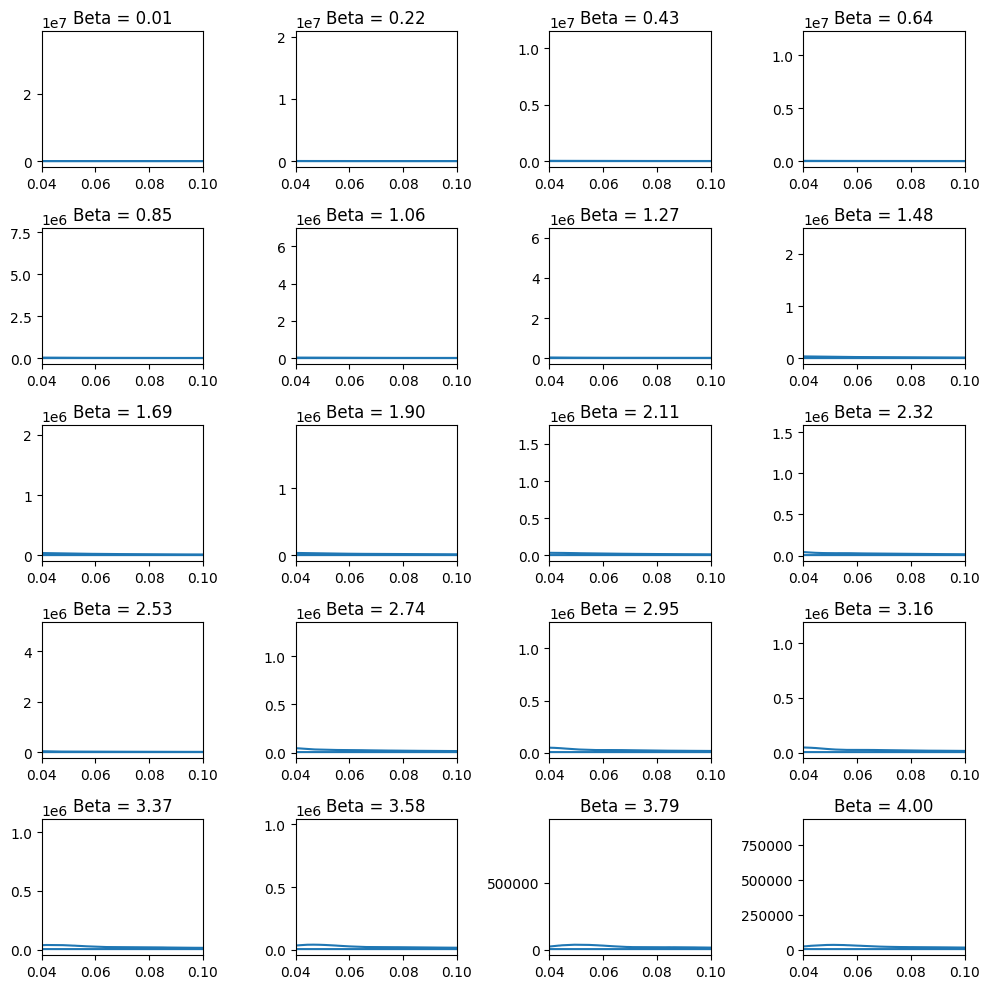

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(10,10))

axs = axs.ravel()

for i, beta in enumerate(beta_df["beta"].unique()):

    ax = axs[i]
    data = grouped_beta.loc[("S", beta)][:-6]
    freq = np.fft.fftfreq(len(data))
    fft_values = np.fft.fft(data)
    
    ax.plot(freq, np.abs(fft_values))
    ax.set_title(f'Beta = {beta:.2f}')
    ax.set_xlim((0.04, 0.1))
    
# Remove any remaining empty subplots
for i in range(len(beta_df["beta"].unique()), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

## Extinction events and Critical Community Size
> Design an experiment that shows the effect of varying $R_0$ on the extinction process. *Keep in mind that in the closed system randomness will always eventually lead to extinction*. 

> Look at how the extinction events are impacted by the population size. Find a way to show how the two parameter $R_0$ and $N$ ineract to impact the extinction process.

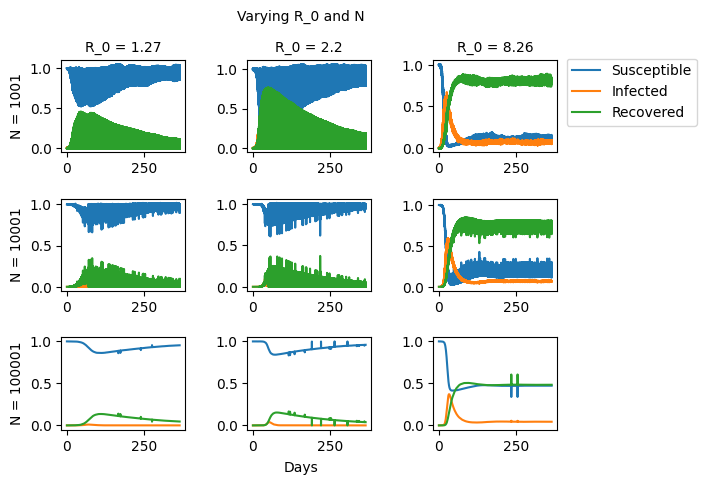

In [111]:
grouped = gamma_N_df.groupby(["group"])
grouped_R = gamma_N_df.groupby(["group", "N", "gamma"]).mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in gamma_N_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(3, 3)

# Plotting the data
paramVals_N = gamma_N_df["N"].unique()[:-1]
paramVals_gamma = gamma_N_df["gamma"].unique()[1::3]
paramVals_gamma = paramVals_gamma[::-1]

for i in range(3): 
    for j in range(3):
        axs[i,j].plot(numbers, grouped_R.loc[("S", paramVals_N[i], paramVals_gamma[j])][:-5], label='Susceptible')
        axs[i,j].plot(numbers, grouped_R.loc[("I", paramVals_N[i], paramVals_gamma[j])][:-5], label='Infected')
        axs[i,j].plot(numbers, grouped_R.loc[("R", paramVals_N[i], paramVals_gamma[j])][:-5], label='Recovered')
    axs[i,0].set_ylabel(f"N = {round(paramVals_N[i], 2)}")
    axs[0,i].set_title(f"R_0 = {round(0.5/(paramVals_gamma[i] + 0.005), 2)}", fontsize = 10)

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 4.09))
fig.text(0.5, 0.03, "Days", ha='center', va='center')
fig.text(0.5, 0.97, "Varying R_0 and N", ha='center', va='center', rotation='horizontal')
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


## SIR Model on Networks

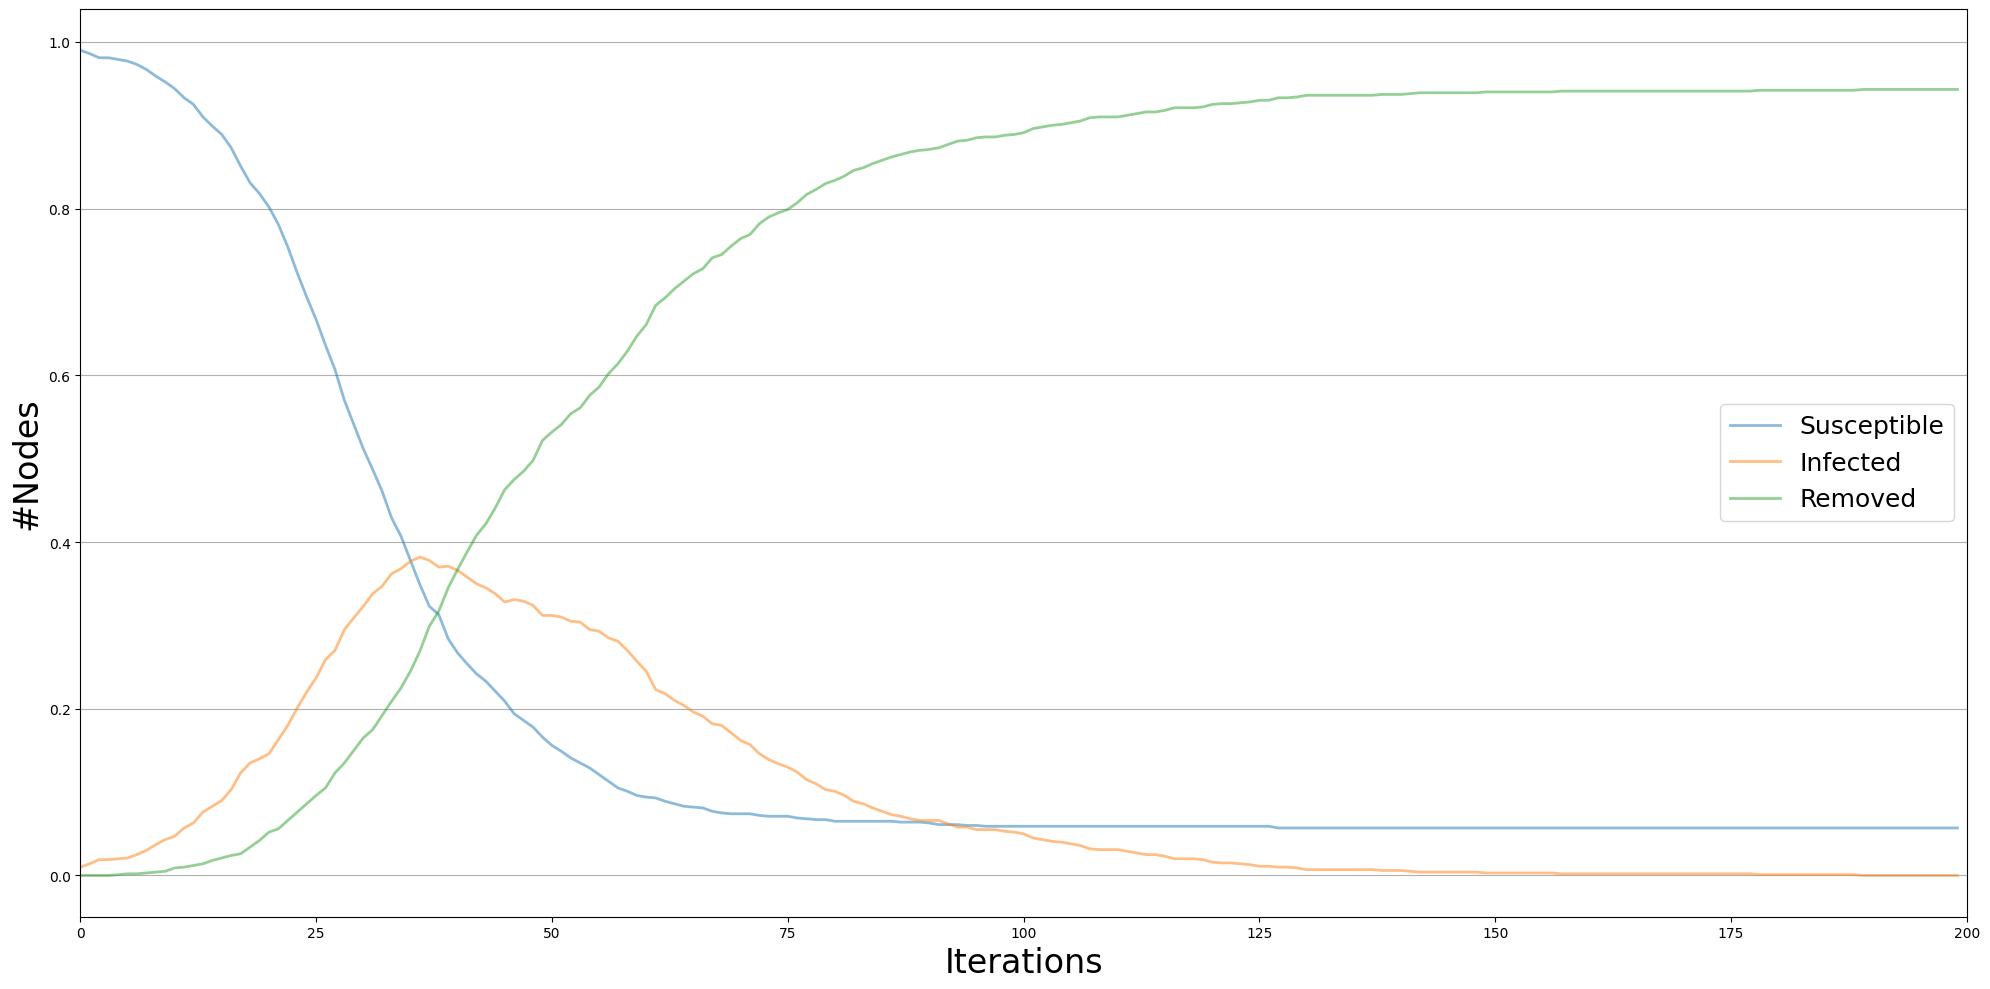

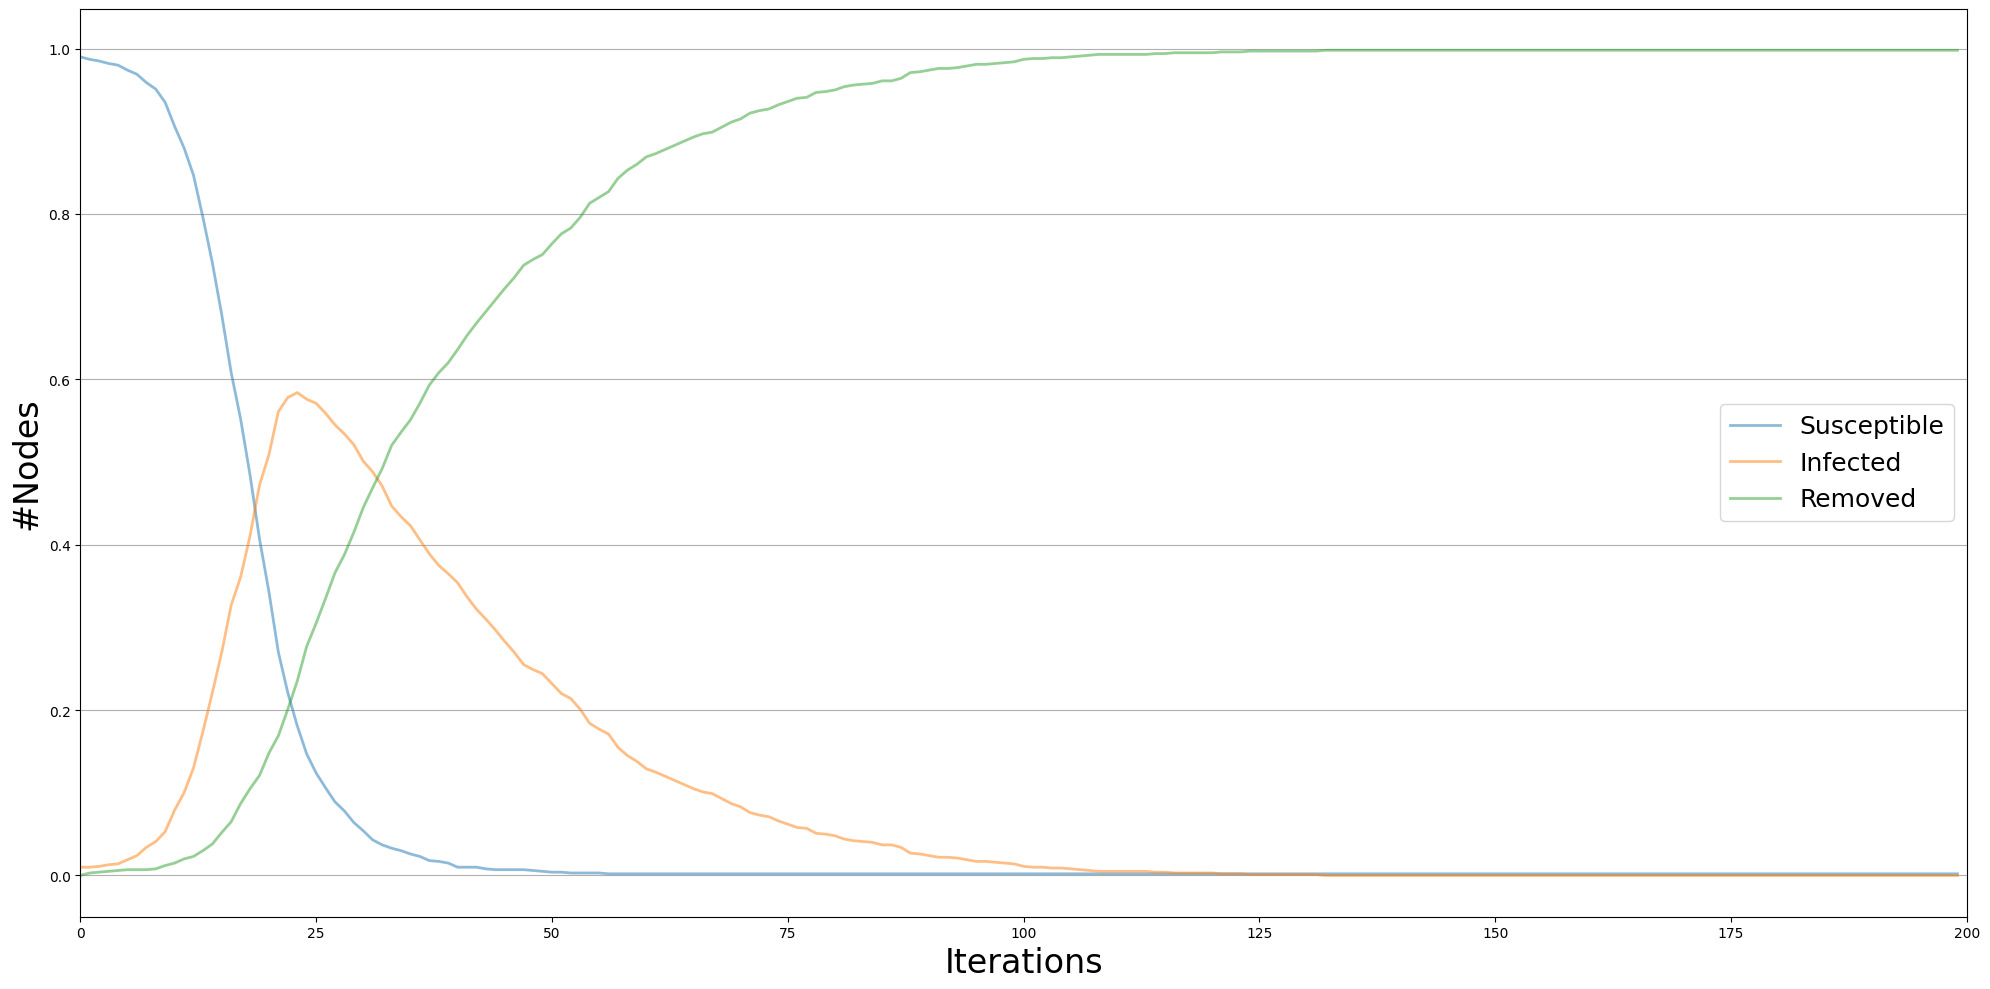

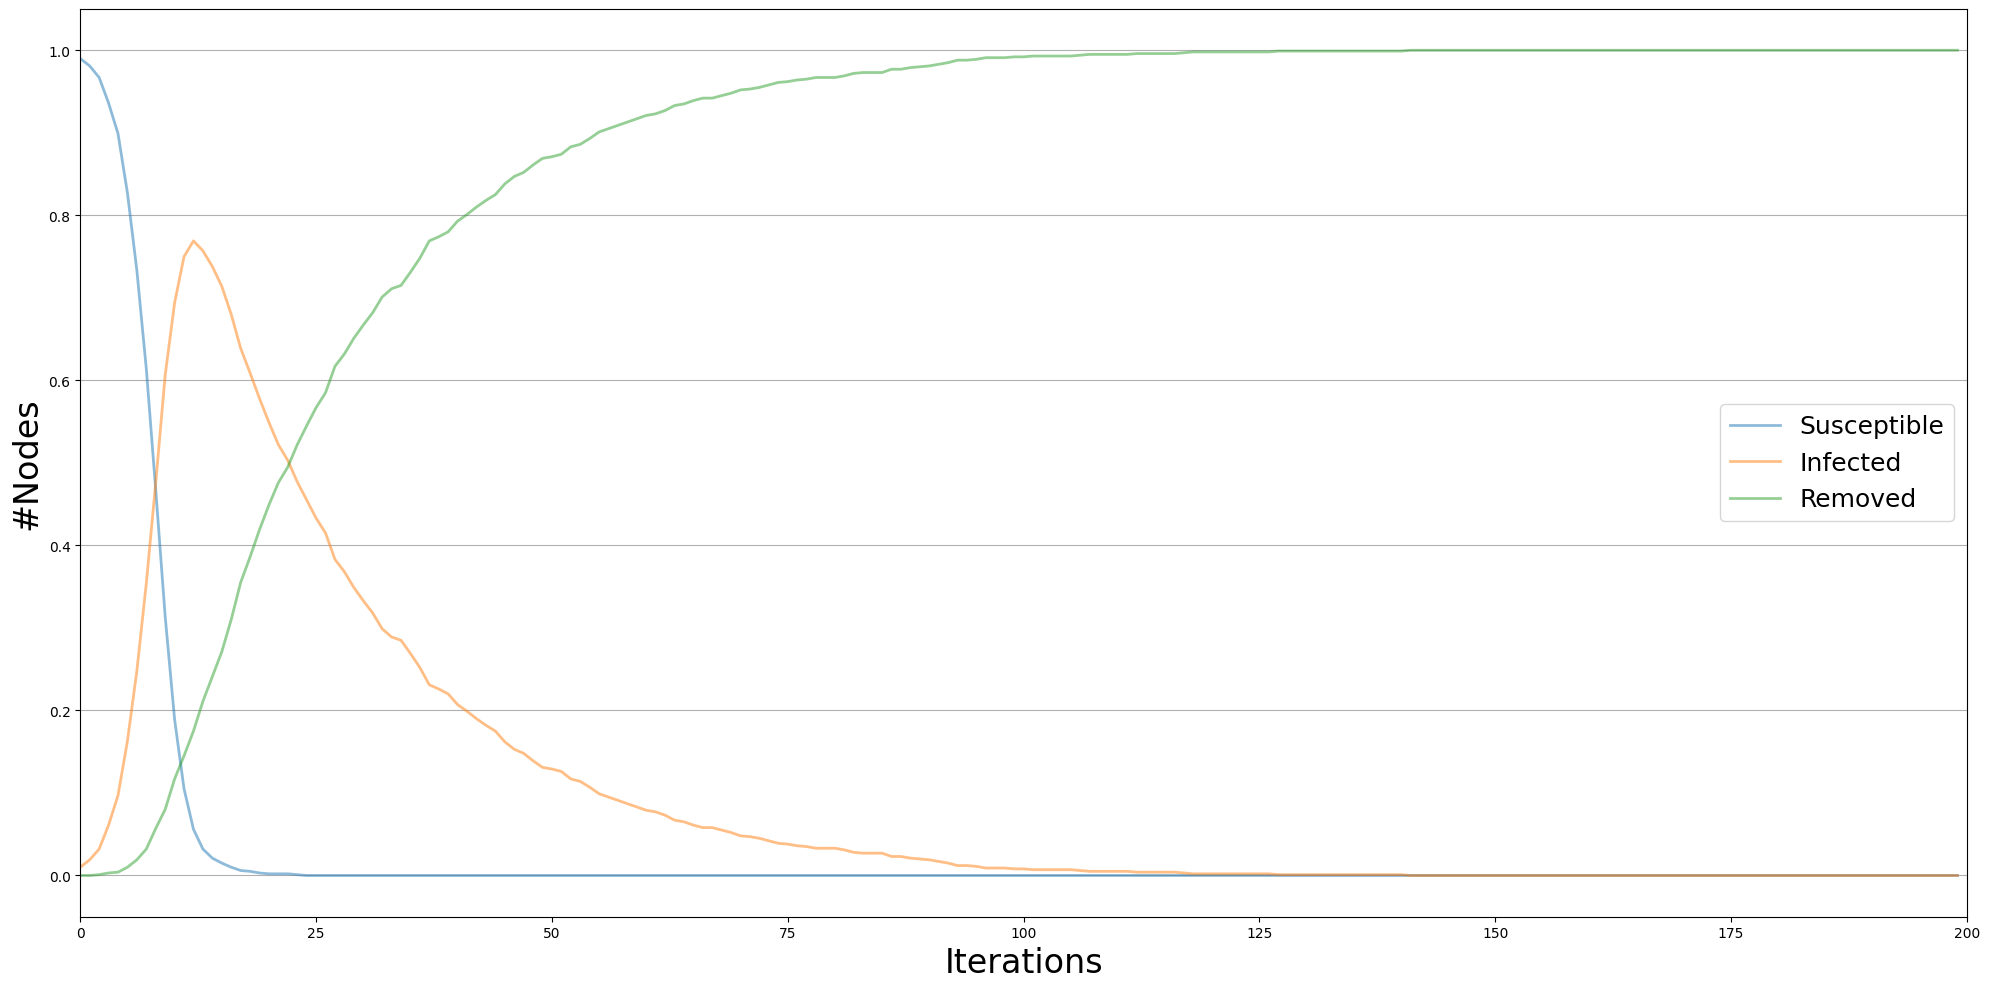

In [ ]:
import ndlib.models.ModelConfig as mc
from bokeh.io import output_notebook, show
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend


# nx.draw_networkx_edges(graph,pos=nx.spring_layout(graph))
def give_plot(graph):
    model = ep.SIRModel(graph)



    ## configuring model

    config = mc.Configuration()
    config.add_model_parameter("beta", 1/100)
    config.add_model_parameter("gamma", 1/20)
    config.add_model_parameter("fraction_infected", 0.01)
    model.set_initial_status(config)

    ## Excuting the simulation

    iterations = model.iteration_bunch(200)
    trends = model.build_trends(iterations)

    ## Visualizing
    visual = DiffusionTrend(model, trends)
    plot = visual.plot()
    
# graphER = nx.erdos_renyi_graph(1000,0.02)
# graphER1 = nx.erdos_renyi_graph(1000,0.04)
# graphER2 = nx.erdos_renyi_graph(1000,0.08)
graphBA = nx.barabasi_albert_graph(1000,15)
graphBA = nx.barabasi_albert_graph(1000,15)
graphBA = nx.barabasi_albert_graph(1000,15)
# graphWS = nx.watts_strogatz_graph(1000,20,0.000000000001)

give_plot(graphER)
give_plot(graphER1)
give_plot(graphER2)

# give_plot(graphBA)
# give_plot(graphWS)

## SIR NETWORKS
In SIR networks, beta should(?) be smaller than gamma in order to get similar behavior to a regular SIR. Not true?

ER: Homogenous mixing, and we expect all nodes to have the "average" number of edges, which leads to little to no pockets for the infection to get stuck in. Changing beta 
 - For low value of P, the disease does not infect all susceptibles, it most likely gets stuck source:Amir

BA: Any node is most likely connected to a hub, therefore it is very unlikely to get "stuck" somewhere where the disease has no susceptibles to spread to. 

WS: When taking k to be the mean degree of an ER model and setting P to 1, we expect WS and ER to behave very similarly. considering the graph is now fully randomly initialize.


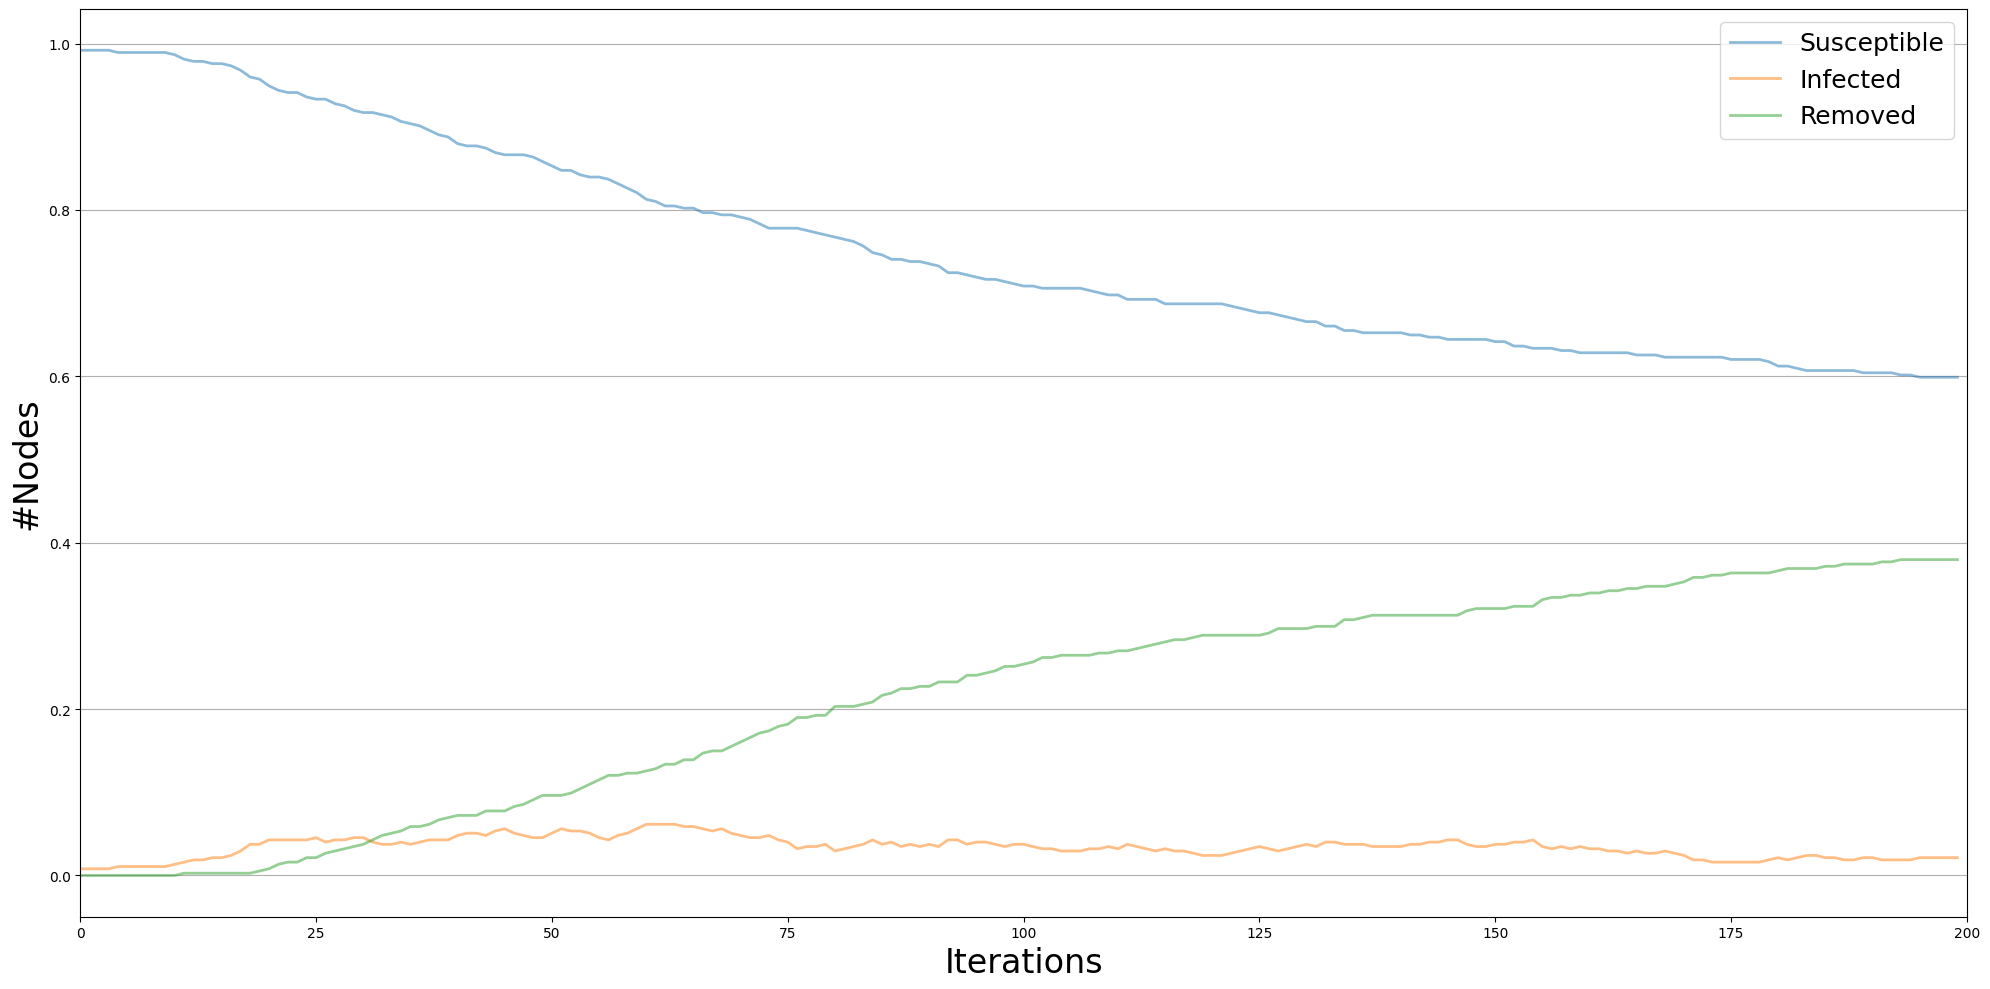

In [ ]:
f= pd.read_csv("transmission_network.csv", header=0, index_col = 0, delimiter=";")
for column in f.columns:
    f[column] = [1 if x else 0 for x in f[column]]
graph_part2 = nx.Graph(f.values)

give_plot(graph_part2)